# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

**Install scnet using pip**

**It may be necessary to restart (not delete) the runtime after installing ScENT in Google Colab. We are working on fixing this issue in future releases.**

In [1]:
!pip install scnet

**Download example data**

In [2]:
!pip install gdown

In [3]:
import gdown
import os
download_url = f'https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi'
output_path = './example.h5ad'
if not os.path.exists(output_path):
    gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi
From (redirected): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi&confirm=t&uuid=4eb2ba11-76dc-4199-943a-7c58536db4bf
To: /Users/belter/github/scNET/example.h5ad
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.38G/1.38G [02:01<00:00, 11.3MB/s]


'./example.h5ad'

# Import scNET and model traning

In [4]:
import scNET
#For faster processing in medium to large datasets (e.g. 30K or above cells), the maximum cells batch size can be increased depending on the available GPU memory.

#For GPU with 24GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 3000

#for GPU with 40GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 4000

#For GPU with 80GB memory or more
scNET.main.MAX_CELLS_BATCH_SIZE = 8000

#otherwize, do not change the default value

In [5]:
#To control the cutoff of gene expression, the minimum precetage of cells expressing a gene can be adjusted. The default all expressed genes are considered.
#For example, to consider genes expressed in at least 5% of cells
#scNET.main.EXPRESSION_CUTOFF = 0.05

In [6]:
#For larger dataset (10K or above), containing larger number of subcommunities, the number of encoder layers could be increased to 4 or more. the default value is 3.
scNET.main.NUM_LAYERS = 3

## run_scNET arguments:
 **obj (AnnData, optional):** AnnData obj.

  **pre_processing_flag (bool, optional):** If True, perform pre-processing steps.

  **human_flag (bool, optional):** Controls gene name casing in the network.

  **number_of_batches (int, optional):** Number of mini-batches for the training.

  **split_cells (bool, optional):** If True, split by cells instead of edges during training. If using A100 could be True (for 10K cells or less)

  **n_neighbors (int, optional):** Number of neighbors for building the adjacency graph.

  **max_epoch (int, optional):** Max number of epochs for model training (recommended 250-300, and for larger dataset consider also 300-350).

  **model_name (str, optional):** Identifier for saving the model outputs.
  
  **save_model_flag (bool, optional):** If True, save the trained model.

In [7]:
import scanpy as sc
obj = sc.read_h5ad("./example.h5ad")
scNET.run_scNET(obj, pre_processing_flag=False, human_flag=False, number_of_batches=10, split_cells=True, max_epoch=300, model_name = "test")


/Users/belter/github/scNET/scNET/Data/format_h_sapiens.csv
N genes: (11049, 9172)
Highly variable genes: 1933


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [18:58:31<00:00, 227.70s/it]


Best Network AUC: 0.8873226887899429



# Using the model's outputs

**Load all the relevant embeddings**


In [8]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("test")

**Create Scanpy object based on the reconstructed gene expression**


In [9]:
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
recon_obj = scNET.create_reconstructed_obj(node_features, out_features, obj)

**Plot marker genes**

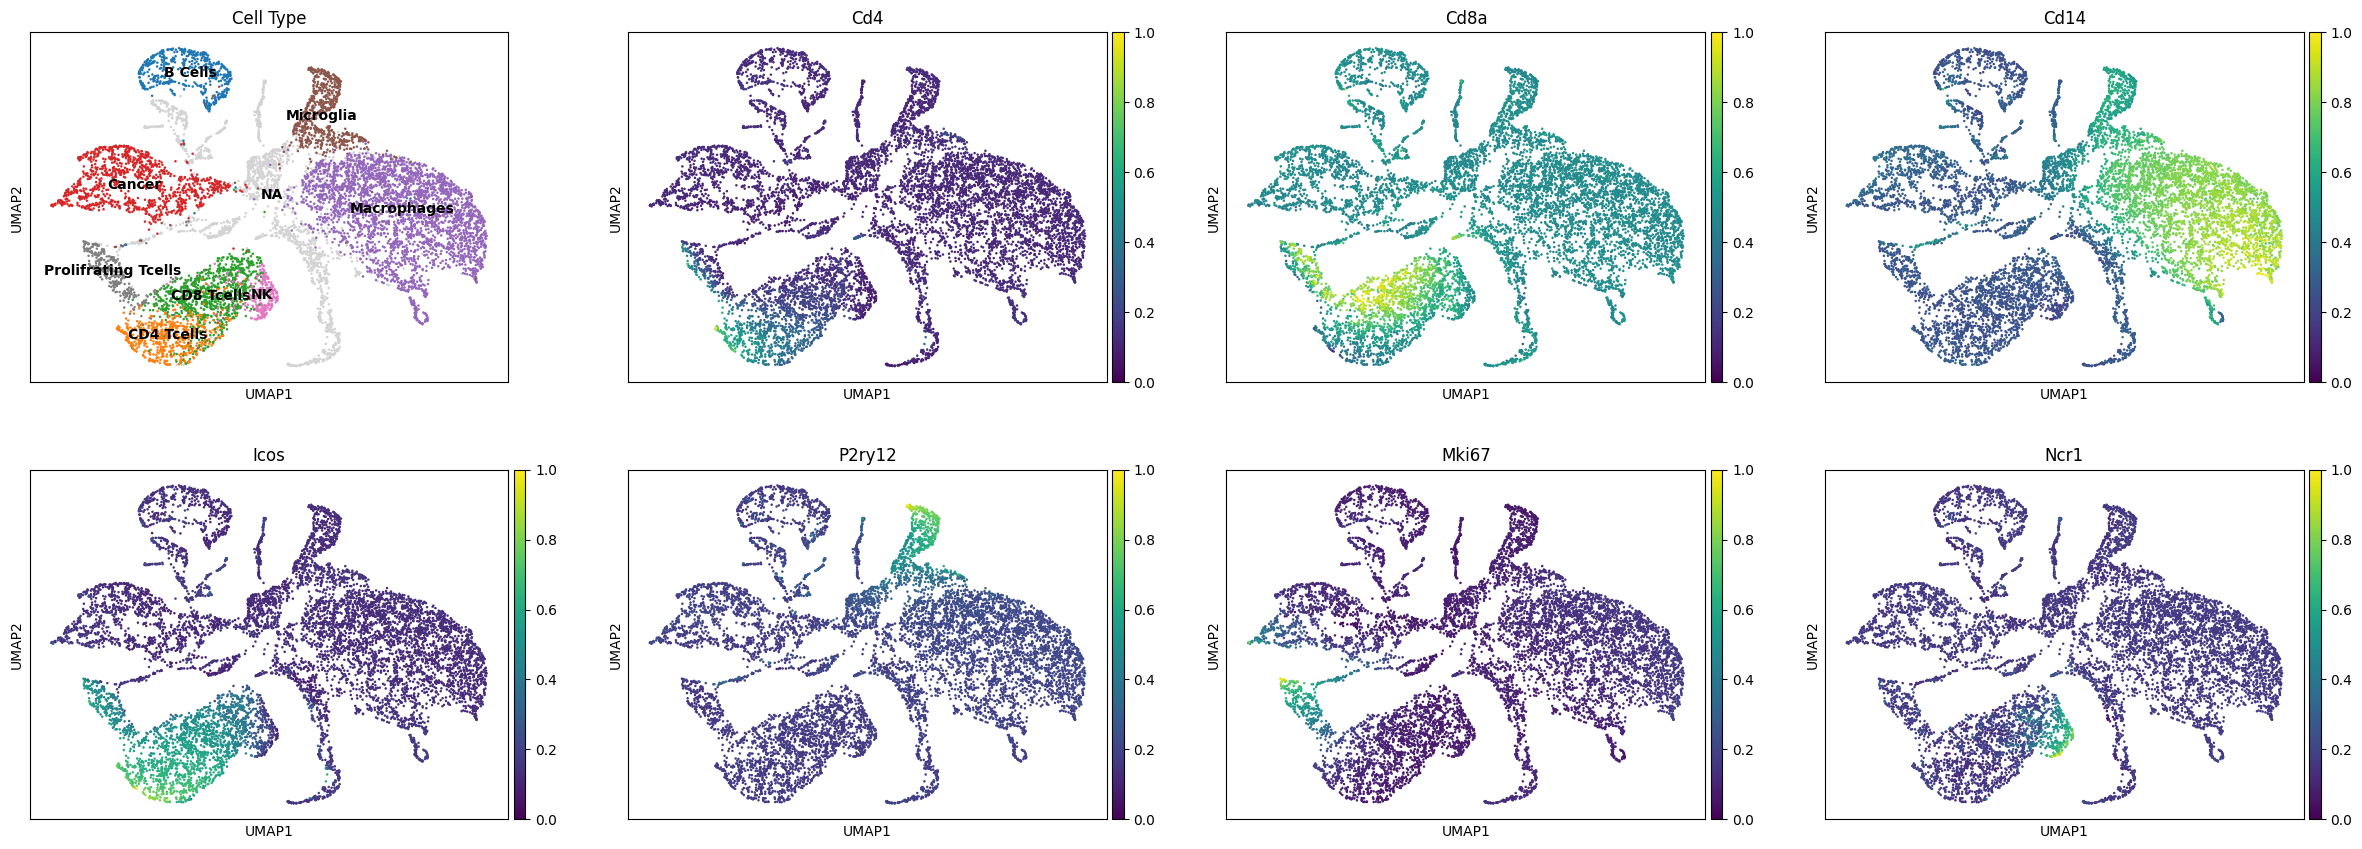

In [10]:
sc.pl.umap(recon_obj, color=["Cell Type","Cd4","Cd8a","Cd14","Icos","P2ry12","Mki67","Ncr1"], show=True, legend_loc='on data')

**Propagation based signature projection for actvation of Tcells**



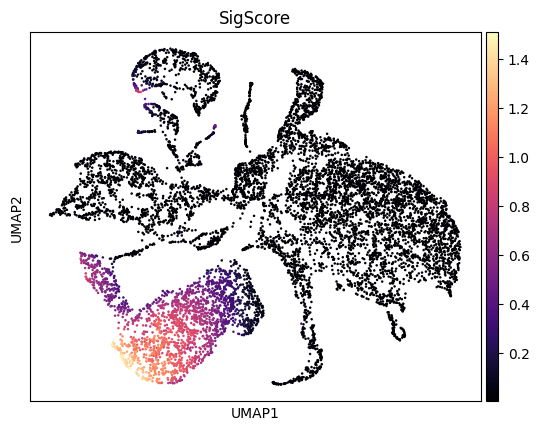

array([0.50663473, 0.71713855, 0.00269838, ..., 0.55515552, 0.0049502 ,
       0.06480582])

In [11]:
scNET.run_signature(recon_obj, up_sig=["Zap70","Lck","Fyn","Cd3g","Cd28","Lat"],alpha = 0.9)

**And for Tumor aggression**

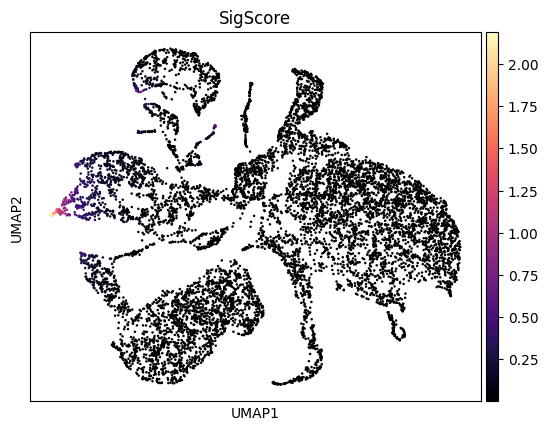

array([0.03257658, 0.48613274, 0.03740461, ..., 0.04823741, 0.00065167,
       0.04838694])

In [12]:

scNET.run_signature(recon_obj,up_sig=["Cdkn2a","Myc","Pten","Kras"])


**Creating the co-embedded network, is it modular?**

In [13]:
import networkx as nx
net, mod = scNET.build_co_embeded_network(embedded_genes, node_features)
print(f"The network mdularity: {mod}")

The network mdularity: 0.7864022424132835


##  Finding Downstream Transcription factors

### Re-embed the T-cells subset

In [14]:
sub_obj = obj[obj.obs["Cell Type"] == "CD8 Tcells"]
scNET.run_scNET(sub_obj, pre_processing_flag=False, human_flag=False, number_of_batches=3, split_cells=False, max_epoch=300, model_name = "Tcells")
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("Tcells")
net, mod = scNET.build_co_embeded_network(embedded_genes, node_features, 99.5)
print(f"The network mdularity: {mod}")

/Users/belter/github/scNET/scNET/Data/format_h_sapiens.csv
N genes: (9624, 906)


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [4:13:22<00:00, 50.68s/it]


Best Network AUC: 0.8839568626371397
The network mdularity: 0.7696529278179087


### Find downstream TF's for a spesific gene signature

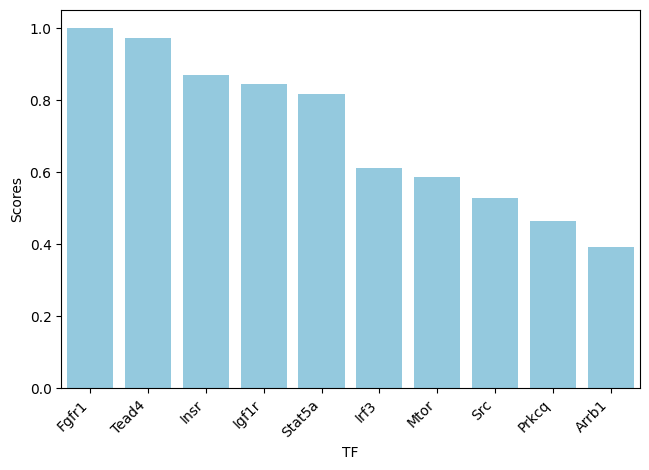

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

tf_scores = scNET.find_downstream_tfs(net, ["Zap70","Lck","Fyn","Cd3g","Cd28","Lat"]).sort_values(ascending=False).head(10)

ax = sns.barplot(x=tf_scores.index, y=tf_scores.values, color='skyblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
ax.set_xlabel('TF')
ax.set_ylabel('Scores')
plt.show()



**Finding differential enriched pathways**
### Can we see a difference in phenotype between Cancer, Microglia and Macrophages?








<Figure size 1000x3000 with 0 Axes>

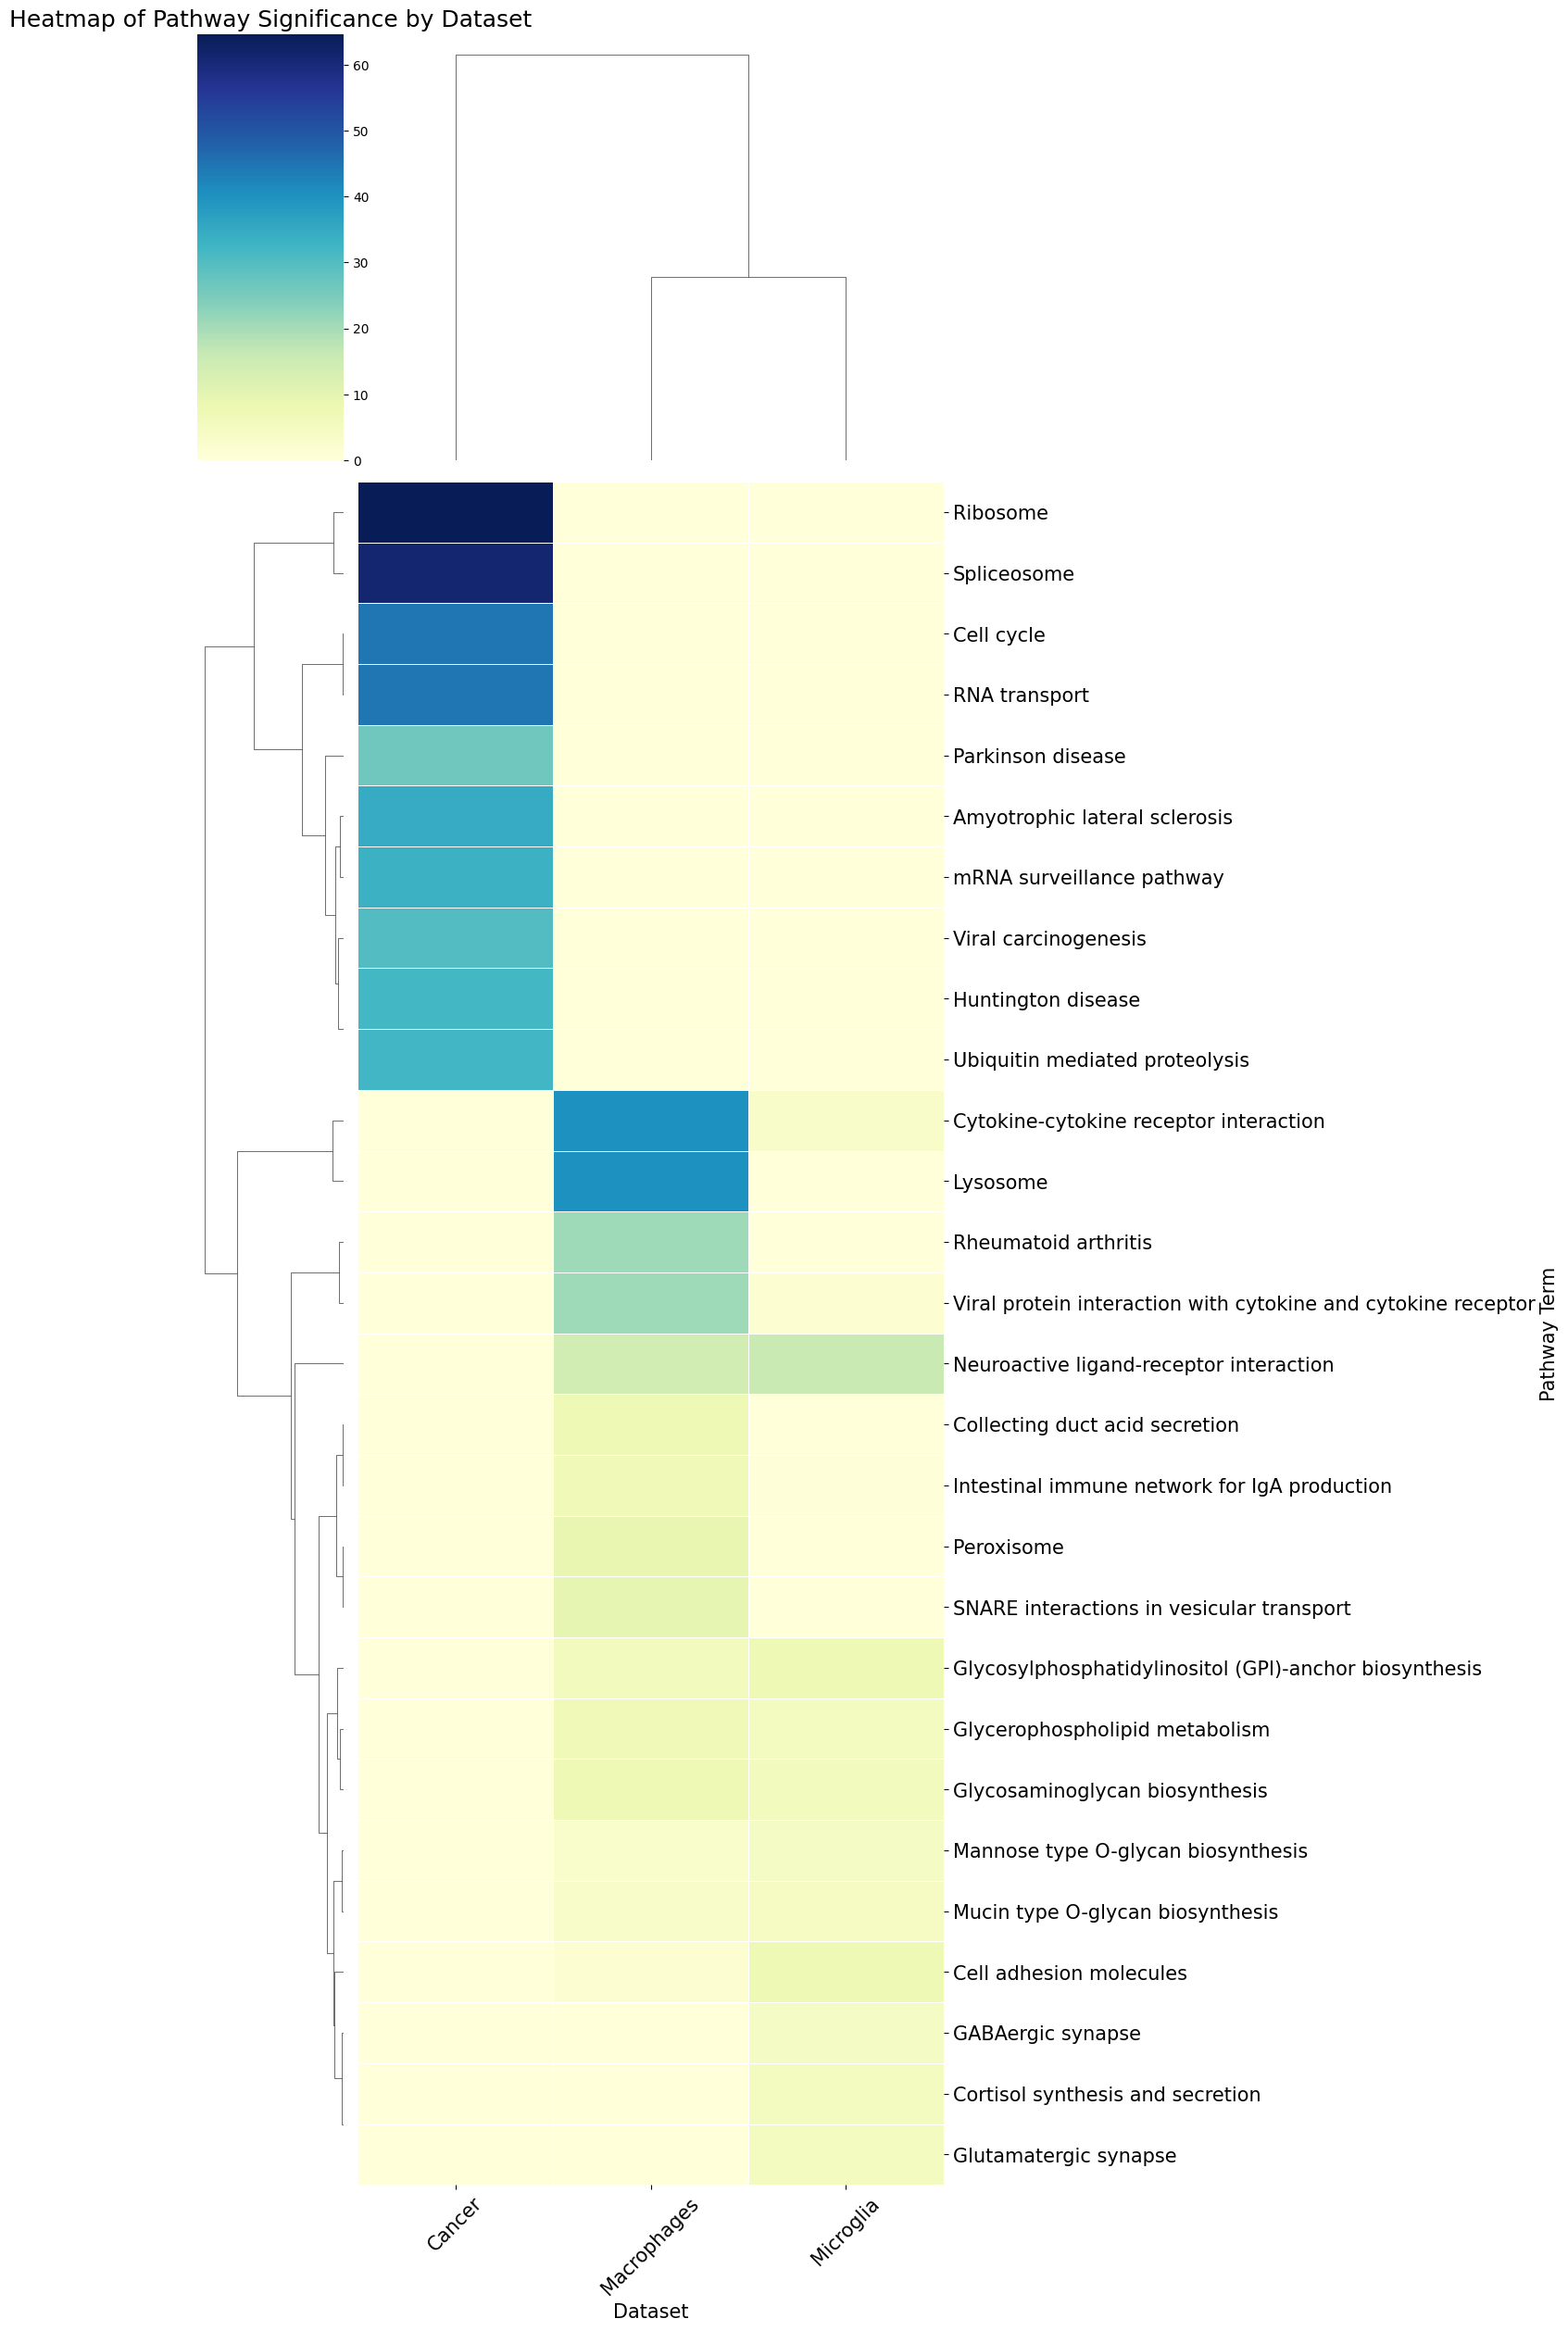

In [16]:
recon_obj.obs["Cell Type"] = recon_obj.obs.seurat_clusters.map(cell_types)
de_genes_per_group, significant_pathways, filtered_kegg, enrichment_results = scNET.pathway_enricment(recon_obj.copy()[recon_obj.obs["Cell Type"].isin(["Microglia","Macrophages","Cancer"])],groupby="Cell Type")
scNET.plot_de_pathways(significant_pathways,enrichment_results,10)